# Homework 08 LSTM Stock Predictions

# Step 1. Import the data from the given .csv file (Google_Stock_Price_Train.csv (https://sjsu.instructure.com/courses/1585768/files/75906517/download?download_frd=1) ).

In [194]:
import pandas as pd

In [268]:
df = pd.read_csv("Google_Stock_Price_Train.csv")
df.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"


In [269]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Open,1258.0,533.709833,151.904442,279.12,404.115,537.47,654.9225,816.68
High,1258.0,537.880223,153.008811,281.21,406.765,540.75,662.5875,816.68
Low,1258.0,529.007409,150.552807,277.22,401.765,532.99,644.8000,805.14


In [270]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1258 non-null   object 
 1   Open    1258 non-null   float64
 2   High    1258 non-null   float64
 3   Low     1258 non-null   float64
 4   Close   1258 non-null   object 
 5   Volume  1258 non-null   object 
dtypes: float64(3), object(3)
memory usage: 59.1+ KB


# Step 2. Preprocess the data as you see fit


In [271]:
df['Volume'] = df['Volume'].str.replace(',', '').astype(int)
df['Close'] = df['Close'].str.replace(',', '').astype(float)
df['Date'] = pd.to_datetime(df['Date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    1258 non-null   datetime64[ns]
 1   Open    1258 non-null   float64       
 2   High    1258 non-null   float64       
 3   Low     1258 non-null   float64       
 4   Close   1258 non-null   float64       
 5   Volume  1258 non-null   int64         
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 59.1 KB


In [272]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
Date,1258,2014-07-03 20:00:45.786963456,2012-01-03 00:00:00,2013-04-05 18:00:00,2014-07-05 00:00:00,2015-10-01 18:00:00,2016-12-30 00:00:00,NaN
Open,1258.0,533.709833,279.12,404.115,537.47,654.9225,816.68,151.904442
High,1258.0,537.880223,281.21,406.765,540.75,662.5875,816.68,153.008811
Low,1258.0,529.007409,277.22,401.765,532.99,644.8,805.14,150.552807
Close,1258.0,712.669666,491.2,576.74,695.675,782.105,1216.83,164.752591
Volume,1258.0,3158106.756757,7900.0,1621700.0,2566150.0,4122500.0,24977900.0,2273725.584816


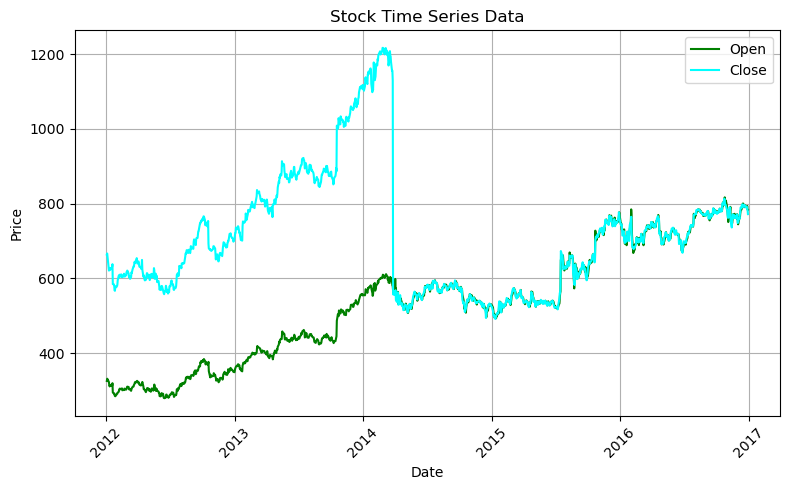

In [274]:
import matplotlib.pyplot as plt

def plot_stocks(df):
    plt.figure(figsize=(8, 5))

    # Plotting High and Low prices
    # plt.plot(df['Date'], df['High'], label='High', color='blue')
    # plt.plot(df['Date'], df['Low'], label='Low', color='red')
    plt.plot(df['Date'], df['Open'], label='Open', color='green')
    plt.plot(df['Date'], df['Close'], label='Close', color='cyan')

    # Plotting Open and Close prices as markers
    # plt.plot(df['Date'], df['Open'], marker='o', linestyle='-', color='green', label='Open')
    # plt.plot(df['Date'], df['Close'], marker='o', linestyle='-', color='orange', label='Close')

    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.title('Stock Time Series Data')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    
plot_stocks(df)

In [275]:
def filter_bad_closing_records(df):
    given_date = '3/27/2014'
    given_date = pd.to_datetime(given_date)
    print("filter based on he date = ", given_date)
    df = df[df['Date']>= given_date]
    return df
    

In [323]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))

def scale_features(data):
    print("Scaling the data ")
    print(f" \t sample input = {data[:5] = }")
    scaled_data = scaler.fit_transform(np.array(data)[... , None]).squeeze()
    print(f" \t Shape of the {scaled_data.shape=} \n")
    return scaled_data

# Step 3. Split into 80% train 20% prediction


In [318]:
import math

import numpy as np

def create_dataset(data, look_back):
    X = []
    y = []
    for i in range(len(data) - look_back):
        X.append(data[i : i + look_back])
        y.append(data[i + look_back])

    return np.array(X)[... , None], np.array(y)[... , None]



def train_test_split(X, test_size=.2, look_back=7):
    X, y = create_dataset(X, look_back)
    # print(f"converting lookbacks shape : {X.shape = }, {y.shape = } ")    
    X_train = torch.from_numpy(X[:int(0.8 * X.shape[0])]).float()
    y_train = torch.from_numpy(y[:int(0.8 * X.shape[0])]).float()
    X_test = torch.from_numpy(X[int(0.8 * X.shape[0]):]).float()
    y_test = torch.from_numpy(y[int(0.8 * X.shape[0]):]).float()
    
    print(f"Training Data Size = {X_train.shape = }, {y_train.shape = }")
    print(f"Test Data Size     = {X_test.shape = }, {y_test.shape = }")
    
    return X_train, X_test, y_train, y_test
  
    

column = "Open"
print(f"Size of the data {len(df)}")
X = df[column].values
print(f"length of the values = {len(X) = }")
scaled_data = scale_features(X)
X_train, X_test, y_train, y_test = train_test_split(scaled_data, test_size=0.2, look_back=5)
print(f"\n sample Data {X_train[:1] = }")

Size of the data 1258
length of the values = len(X) = 1258
Scaling the data 
 	 sample input = data[:5] = array([325.25, 331.27, 329.83, 328.34, 322.04])
 	 Shape of the scaled_data.shape=(1258,) 

converting lookbacks shape : X.shape = (1253, 5, 1), y.shape = (1253, 1) 
Training Data Size = torch.Size([1002, 5, 1]), torch.Size([1002, 1])
Test Data Size     = torch.Size([251, 5, 1]), torch.Size([251, 1])

 sample Data X_train[:1] = tensor([[[0.0858],
         [0.0970],
         [0.0943],
         [0.0916],
         [0.0798]]])


# Step 4. Train the model on the data


In [311]:
import torch
import torch.nn as nn


class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, output_size=1):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Forward pass through LSTM layer
        out, (hidden, ceil) = self.lstm(x)
        out = self.fc(hidden[-1 , :])
        return out

    
model = LSTMModel(input_size=1, hidden_size=64)
print(model)

In [370]:
def train(model, X_train, y_train, num_epochs=20):
    # Train the model
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    for epoch in range(num_epochs):
        outputs = model(X_train)
        optimizer.zero_grad()
        loss = criterion(outputs, y_train)
        loss.backward()
        optimizer.step()
        if (epoch+1) % (num_epochs//5) == 0:
            print(f'\tEpoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    return model



from sklearn.metrics import mean_squared_error

def evaluate(model, X_test, y_test, look_back):
    model.eval()
    with torch.no_grad():
        output = model(X_test)
    
    y_pred = scaler.inverse_transform(output.numpy())
    y_real = scaler.inverse_transform(y_test.numpy())
    
    # Calculate RMSE for the testing set
    test_rmse = np.sqrt(mean_squared_error(y_real, y_pred))
    print(f"Testing RMSE for look_back = {look_back}: {test_rmse}")

    return test_rmse



def plot_results(model, X_test, y_test, look_back):
    model.eval()
    with torch.no_grad():
        output = model(X_test)
    
    y_pred = scaler.inverse_transform(output.numpy())
    y_real = scaler.inverse_transform(y_test.numpy())
    
    plt.figure(figsize=(8, 4))
    plt.title(f"Real Price and Predicted Price for the look_back period = {look_back}")
    plt.plot(y_pred.squeeze(), label = "predicted")
    plt.plot(y_real.squeeze(), label = "real")
    plt.legend(loc='upper left', fontsize=14)
    plt.grid(True)
    plt.show()
    

length of the values = len(X) = 1258
Scaling the data 
 	 sample input = data[:5] = array([663.59, 666.45, 657.21, 648.24, 620.76])
 	 Shape of the scaled_data.shape=(1258,) 

converting lookbacks shape : X.shape = (1253, 5, 1), y.shape = (1253, 1) 
Training Data Size = torch.Size([1002, 5, 1]), torch.Size([1002, 1])
Test Data Size     = torch.Size([251, 5, 1]), torch.Size([251, 1])
	Epoch [20/100], Loss: 0.0513
	Epoch [40/100], Loss: 0.0356
	Epoch [60/100], Loss: 0.0115
	Epoch [80/100], Loss: 0.0042
	Epoch [100/100], Loss: 0.0032
Testing RMSE for look_back = 5: 22.856735229492188


 Best Performance So far for the Lookback period = 5


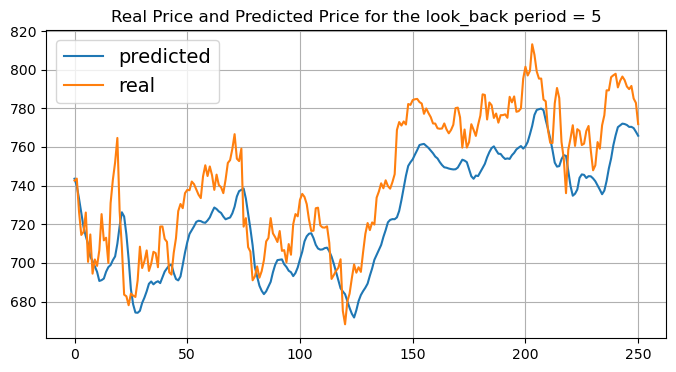

converting lookbacks shape : X.shape = (1252, 6, 1), y.shape = (1252, 1) 
Training Data Size = torch.Size([1001, 6, 1]), torch.Size([1001, 1])
Test Data Size     = torch.Size([251, 6, 1]), torch.Size([251, 1])
	Epoch [20/100], Loss: 0.0502
	Epoch [40/100], Loss: 0.0271
	Epoch [60/100], Loss: 0.0045
	Epoch [80/100], Loss: 0.0038
	Epoch [100/100], Loss: 0.0034
Testing RMSE for look_back = 6: 26.73886489868164
converting lookbacks shape : X.shape = (1251, 7, 1), y.shape = (1251, 1) 
Training Data Size = torch.Size([1000, 7, 1]), torch.Size([1000, 1])
Test Data Size     = torch.Size([251, 7, 1]), torch.Size([251, 1])
	Epoch [20/100], Loss: 0.0472
	Epoch [40/100], Loss: 0.0243
	Epoch [60/100], Loss: 0.0059
	Epoch [80/100], Loss: 0.0042
	Epoch [100/100], Loss: 0.0035
Testing RMSE for look_back = 7: 26.156238555908203
converting lookbacks shape : X.shape = (1250, 8, 1), y.shape = (1250, 1) 
Training Data Size = torch.Size([1000, 8, 1]), torch.Size([1000, 1])
Test Data Size     = torch.Size([2

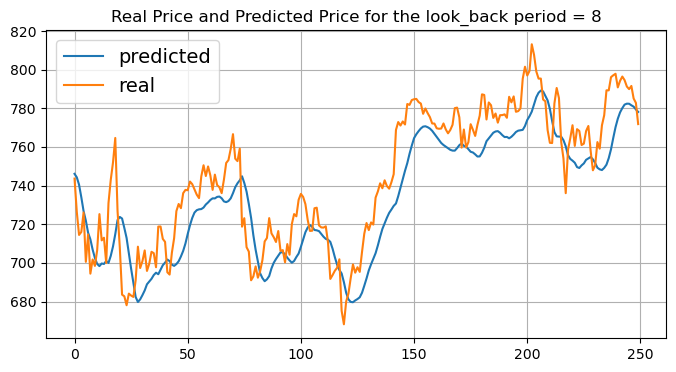

converting lookbacks shape : X.shape = (1249, 9, 1), y.shape = (1249, 1) 
Training Data Size = torch.Size([999, 9, 1]), torch.Size([999, 1])
Test Data Size     = torch.Size([250, 9, 1]), torch.Size([250, 1])
	Epoch [20/100], Loss: 0.0501
	Epoch [40/100], Loss: 0.0340
	Epoch [60/100], Loss: 0.0053
	Epoch [80/100], Loss: 0.0046
	Epoch [100/100], Loss: 0.0039
Testing RMSE for look_back = 9: 27.90312957763672
converting lookbacks shape : X.shape = (1248, 10, 1), y.shape = (1248, 1) 
Training Data Size = torch.Size([998, 10, 1]), torch.Size([998, 1])
Test Data Size     = torch.Size([250, 10, 1]), torch.Size([250, 1])
	Epoch [20/100], Loss: 0.0484
	Epoch [40/100], Loss: 0.0274
	Epoch [60/100], Loss: 0.0073
	Epoch [80/100], Loss: 0.0046
	Epoch [100/100], Loss: 0.0036
Testing RMSE for look_back = 10: 22.188262939453125
converting lookbacks shape : X.shape = (1247, 11, 1), y.shape = (1247, 1) 
Training Data Size = torch.Size([997, 11, 1]), torch.Size([997, 1])
Test Data Size     = torch.Size([2

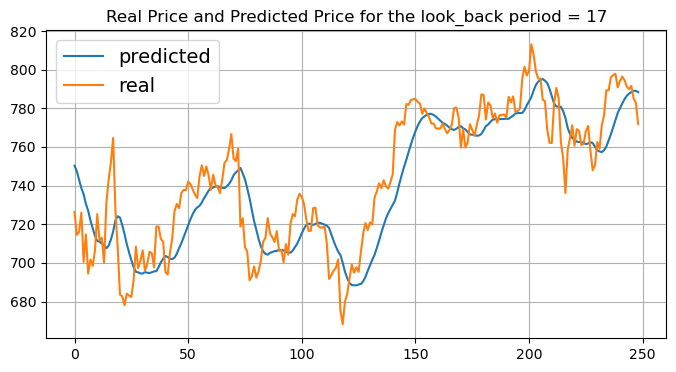

converting lookbacks shape : X.shape = (1240, 18, 1), y.shape = (1240, 1) 
Training Data Size = torch.Size([992, 18, 1]), torch.Size([992, 1])
Test Data Size     = torch.Size([248, 18, 1]), torch.Size([248, 1])
	Epoch [20/100], Loss: 0.0514
	Epoch [40/100], Loss: 0.0260
	Epoch [60/100], Loss: 0.0095
	Epoch [80/100], Loss: 0.0063
	Epoch [100/100], Loss: 0.0047
Testing RMSE for look_back = 18: 27.994932174682617
converting lookbacks shape : X.shape = (1239, 19, 1), y.shape = (1239, 1) 
Training Data Size = torch.Size([991, 19, 1]), torch.Size([991, 1])
Test Data Size     = torch.Size([248, 19, 1]), torch.Size([248, 1])
	Epoch [20/100], Loss: 0.0486
	Epoch [40/100], Loss: 0.0103
	Epoch [60/100], Loss: 0.0064
	Epoch [80/100], Loss: 0.0040
	Epoch [100/100], Loss: 0.0033
Testing RMSE for look_back = 19: 16.423263549804688


 Best Performance So far for the Lookback period = 19


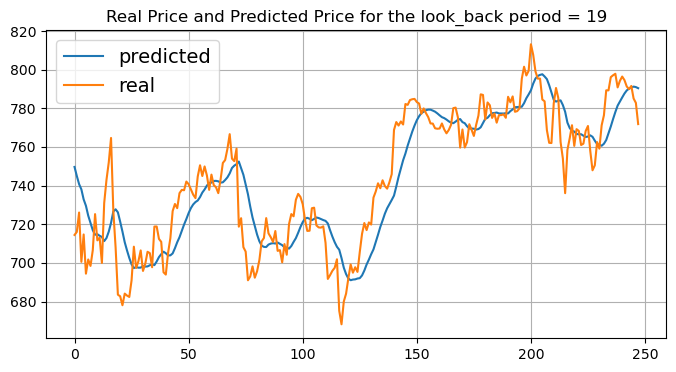

converting lookbacks shape : X.shape = (1238, 20, 1), y.shape = (1238, 1) 
Training Data Size = torch.Size([990, 20, 1]), torch.Size([990, 1])
Test Data Size     = torch.Size([248, 20, 1]), torch.Size([248, 1])
	Epoch [20/100], Loss: 0.0499
	Epoch [40/100], Loss: 0.0104
	Epoch [60/100], Loss: 0.0061
	Epoch [80/100], Loss: 0.0040
	Epoch [100/100], Loss: 0.0033
Testing RMSE for look_back = 20: 16.541051864624023


In [372]:
rmse_dict = {}
look_back_periods = [i for i in range(5, 21)]

column = "Close"

X = df[column].values
print(f"length of the values = {len(X) = }")
scaled_data = scale_features(X)

min_rmse, min_look_back_period = float('inf'), -1

for look_back in look_back_periods:
    X_train, X_test, y_train, y_test = train_test_split(scaled_data, test_size=0.2, look_back=look_back)
    model = LSTMModel(input_size=1, hidden_size=64)
    model = train(model, X_train, y_train, num_epochs=100)    
    rmse_dict[look_back] = (model, evaluate(model, X_test, y_test, look_back))
    
    if rmse_dict[look_back][1] < min_rmse:
        print(f"\n\n Best Performance So far for the Lookback period = {look_back}")
        plot_results(model, X_test, y_test, look_back)
        min_rmse = rmse_dict[look_back][1]
        min_look_back_period = look_back
    

# Step 5. Report on the results of your model

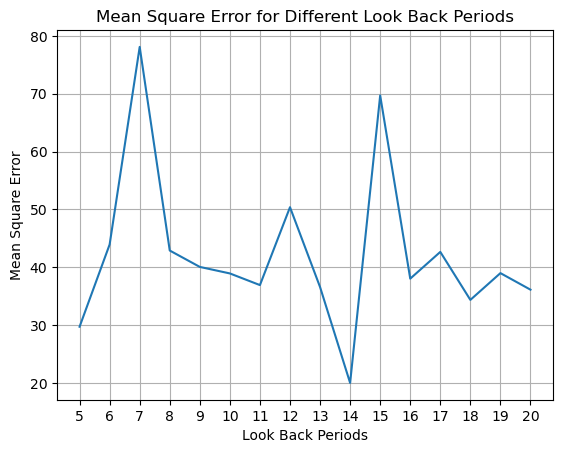

In [366]:
plt.plot([rmse_dict[i][1] for i in look_back_periods])
plt.xlabel('Look Back Periods')
plt.ylabel('Mean Square Error')
plt.title('Mean Square Error for Different Look Back Periods')
xticks_values = np.arange(look_back_periods[0], look_back_periods[-1]+1, 1)
plt.xticks([i for i in range(len(look_back_periods))], look_back_periods) 
plt.grid(True)
plt.show()

converting lookbacks shape : X.shape = (1239, 19, 1), y.shape = (1239, 1) 
Training Data Size = torch.Size([991, 19, 1]), torch.Size([991, 1])
Test Data Size     = torch.Size([248, 19, 1]), torch.Size([248, 1])
1258 1010 248 248


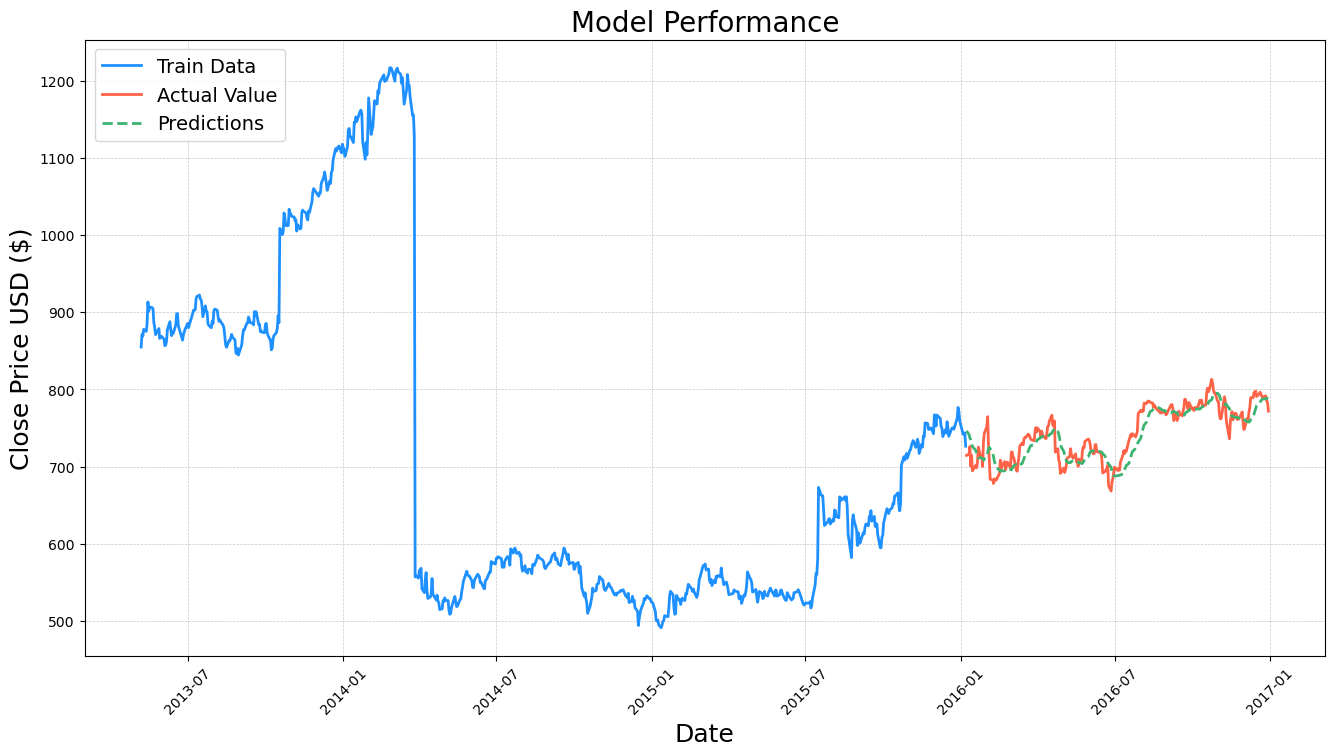

In [382]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


def plot_result(df, N, predictions, look_back):
    
    N_train, N_test = N - len(predictions), len(predictions)
    train = df.iloc[int(N_train/3):N_train].copy()
    print(N, N_train, N_test, len(predictions))

    valid = df.iloc[N_train:].copy()
    valid['Predictions'] = predictions

    # Plotting
    plt.figure(figsize=(16,8))
    plt.title(f'Model Performance for the Columns = {column}', fontsize=20)
    plt.xlabel('Date', fontsize=18)
    plt.ylabel(f'{column} Price USD ($)', fontsize=18)

    # Actual prices for the training part
    plt.plot(train['Date'], train[column], label='Train Data', color='dodgerblue', linewidth=2)

    # Actual prices for the test part
    plt.plot(valid['Date'], valid[column], label='Actual Value', color='tomato', linewidth=2)

    # Predicted prices
    plt.plot(valid['Date'], valid['Predictions'], label='Predictions', color='mediumseagreen', linestyle='--', linewidth=2)

    plt.legend(loc='upper left', fontsize=14)
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    plt.show()

    

for look_back in lookback_periods:
    X_train, X_test, y_train, y_test = train_test_split(scaled_data, test_size=0.2, look_back=min_look_back_period)
    
    model.eval()
    with torch.no_grad():
        output = model(X_test)

    y_pred = scaler.inverse_transform(output.numpy())
    plot_result(df, len(scaled_data), y_pred, min_look_back_period)


In [379]:
len(scaled_data)

1258

In [ ]:
model.eval()
with torch.no_grad():
    output = model(X_test)

y_pred = scaler.inverse_transform(output.numpy())

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates


def plot_result(df, predictions, look_back)
    
    N, N_train, N_test = X.shape[0],  N - len(predictions[look_back]), len(predictions[look_back])
    train = df.iloc[int(N_train/3):N_train].copy()
    print(N, N_train, N_test, len(predictions[look_back]))
    # Preparing the 'valid' DataFrame
    valid = df.iloc[N_train:].copy()
    valid['Predictions'] = predictions[look_back]
    

    # Plotting
    plt.figure(figsize=(16,8))
    plt.title('Model Performance', fontsize=20)
    plt.xlabel('Date', fontsize=18)
    plt.ylabel('Close Price USD ($)', fontsize=18)

    # Actual prices for the training part
    plt.plot(train['Date'], train['Close'], label='Train Data', color='dodgerblue', linewidth=2)

    # Actual prices for the test part
    plt.plot(valid['Date'], valid['Close'], label='Actual Value', color='tomato', linewidth=2)

    # Predicted prices
    plt.plot(valid['Date'], valid['Predictions'], label='Predictions', color='mediumseagreen', linestyle='--', linewidth=2)

    plt.legend(loc='upper left', fontsize=14)
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    plt.show()

    

for look_back in lookback_periods:
    predictions = predict(mode)
    plot_result(df, predictions, look_back)


filter based on he date =  2014-03-27 00:00:00
[[0.35887436]
 [0.35591141]
 [0.3413172 ]
 [0.3535824 ]
 [0.34756005]
 [0.36780453]
 [0.35587007]
 [0.34192357]
 [0.3535824 ]
 [0.3566556 ]] [[0.35591141]
 [0.3413172 ]
 [0.3535824 ]
 [0.34756005]
 [0.36780453]
 [0.35587007]
 [0.34192357]
 [0.3535824 ]
 [0.3566556 ]
 [0.35708281]]
shapes = X_train.shape=torch.Size([991, 10, 1]), y_train.shape=torch.Size([991, 1]), X_test.shape=torch.Size([257, 10, 1])
Epoch [1/200], Loss: 0.1198
Epoch [41/200], Loss: 0.0910
Epoch [81/200], Loss: 0.0764
Epoch [121/200], Loss: 0.0689
Epoch [161/200], Loss: 0.0650


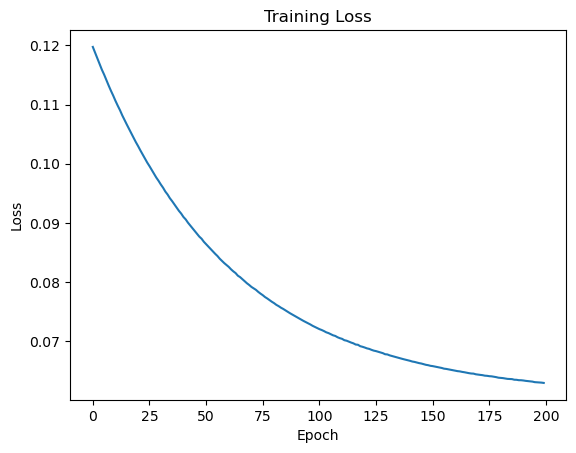

698 441 257 257


ValueError: Length of values (257) does not match length of index (817)

In [253]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from torch import nn
import torch
from torch.utils.data import DataLoader, TensorDataset

# Load the dataset
df = pd.read_csv("Google_Stock_Price_Train.csv")

# Convert 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'])
df['Close'] = df['Close'].str.replace(',', '').astype(float)

# # Filter data to a specific date range if needed
# start_date = '2017-01-01'
# end_date = '2018-01-01'
# df_filtered = df[(df['Date'] >= start_date) & (df['Date'] <= end_date)]
# print(df_filtered)

given_date = '3/27/2014'
given_date = pd.to_datetime(given_date)
print("filter based on he date = ", given_date)
df_filtered = df[df['Date']>= given_date]



# df = df_filtered

#dfExtract the 'Close' column for prediction
data = df['Close'].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0,1))
data_normalized = scaler.fit_transform(data)

def create_sequences(data, look_back):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:(i + look_back)])
        y.append(data[i + look_back])
    return np.array(X), np.array(y)


    
import torch
import torch.nn as nn

# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, output_size=1):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)

        # Forward pass through LSTM layer
        out, _ = self.lstm(x, (h0, c0))

        # Only take the output from the final time step
        out = self.fc(out[:, -1, :])
        return out

    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


# Define the lookback periods to experiment with
lookback_periods = [10]#, 10, 15, 20]

# Hyperparameters
num_epochs = 200
batch_size = 32
learning_rate = 0.0001


# Function to train the model for a given lookback period
def train_model(lookback_period, test_size=0.2):
    X, y = create_sequences(data_normalized, lookback_period)
    # X_train = torch.from_numpy(X).float().to(device)
    # y_train = torch.from_numpy(y).float().to(device)
    
    N = len(X)
    boundary = math.floor((N - look_back + 1) * (1 - test_size))
    X_train, y_train = X[:boundary], y[:boundary]
    X_test, y_test = X[boundary:], y[boundary:]
    print(X_train[-1], X_test[0])
    X_train = torch.from_numpy(X_train).float().to(device)
    y_train = torch.from_numpy(y_train).float().to(device)
    X_test = torch.from_numpy(X_test).float().to(device)
    y_test = torch.from_numpy(y_test).float().to(device)
    
    print(f"shapes = {X_train.shape=}, {y_train.shape=}, {X_test.shape=}")
    train_dataset = TensorDataset(X_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    model = LSTMModel(input_size=1, hidden_size=50).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    # for epoch in range(num_epochs):
    #     model.train()
    #     for batch_X, batch_y in train_loader:
    #         batch_X, batch_y = batch_X.to(device), batch_y.to(device)
    #         optimizer.zero_grad()
    #         outputs = model(batch_X)
    #         loss = criterion(outputs, batch_y)
    #         loss.backward()
    #         optimizer.step()
    
    epoch_losses = []

    for epoch in range(num_epochs):
        model.train()
        batch_losses = []
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            
            batch_losses.append(loss.item())
        
        epoch_loss = sum(batch_losses) / len(batch_losses)
        epoch_losses.append(epoch_loss)
        if(epoch % (num_epochs//5) == 0): print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')
    
    plt.plot(epoch_losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.show()

    
    
    test_dataset = TensorDataset(X_test, y_test)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
    model.eval()
    predictions = []
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            prediction = model(batch_X).cpu().numpy()
            prediction = scaler.inverse_transform(prediction)
            predictions.extend(prediction.flatten())
    
    return predictions


# Train models with different lookback periods and store predictions
predictions = {}
for lookback_period in lookback_periods:
    predictions[lookback_period] = train_model(lookback_period)
    
    
    
    
    
    
    
    
    
    


tensor([[0.2042, 0.2089, 0.1996,  ..., 0.2307, 0.2391, 0.1567],
        [0.2089, 0.1996, 0.2312,  ..., 0.2391, 0.1567, 0.1413],
        [0.1996, 0.2312, 0.2307,  ..., 0.1567, 0.1413, 0.1932],
        ...,
        [0.7431, 0.7180, 0.7000,  ..., 0.7365, 0.7374, 0.7089],
        [0.7180, 0.7000, 0.7004,  ..., 0.7374, 0.7089, 0.7057],
        [0.7000, 0.7004, 0.7365,  ..., 0.7089, 0.7057, 0.7054]])